In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas_bokeh
pandas_bokeh.output_notebook()

import scikitplot as skplt
import seaborn as sns
sns.set()

from sklearn import metrics
from sklearn.model_selection import cross_validate

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20

Loading BokehJS ...

In [2]:
#importing datasets

cab_df = pd.read_csv("Cab_Data.csv")
cab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359392 entries, 0 to 359391
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Transaction ID  359392 non-null  int64  
 1   Date of Travel  359392 non-null  int64  
 2   Company         359392 non-null  object 
 3   City            359392 non-null  object 
 4   KM Travelled    359392 non-null  float64
 5   Price Charged   359392 non-null  float64
 6   Cost of Trip    359392 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 19.2+ MB


In [3]:
cab_df.isna().sum()

Transaction ID    0
Date of Travel    0
Company           0
City              0
KM Travelled      0
Price Charged     0
Cost of Trip      0
dtype: int64

There are no missing values in this dataset.

In [4]:
cab_df.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.635
1,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.854
2,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.632
3,10000014,42376,Pink Cab,ATLANTA GA,33.17,377.40,351.602
4,10000015,42372,Pink Cab,ATLANTA GA,8.73,114.62,97.776


The `Date of Travel` is of serial number format. Extracting data information from this column.

In [5]:
from datetime import datetime
import xlrd

In [6]:
%%time
dates = [
    pd.to_datetime(xlrd.xldate_as_datetime(date, 0)) for date in cab_df['Date of Travel']
] 

Wall time: 24.1 s


In [7]:
cab_df['Travel_Date'] = dates

In [8]:
cab_df.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Travel_Date
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.635,2016-01-08
1,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.854,2016-01-06
2,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.632,2016-01-02
3,10000014,42376,Pink Cab,ATLANTA GA,33.17,377.40,351.602,2016-01-07
4,10000015,42372,Pink Cab,ATLANTA GA,8.73,114.62,97.776,2016-01-03


In [9]:
#Dropping 'Date of Travel' column
cab_df.drop('Date of Travel', axis = 1, inplace = True)

In [10]:
cab_df.head()

,Transaction ID,Company,City,KM Travelled,Price Charged,Cost of Trip,Travel_Date
0,10000011,Pink Cab,ATLANTA GA,30.45,370.95,313.635,2016-01-08
1,10000012,Pink Cab,ATLANTA GA,28.62,358.52,334.854,2016-01-06
2,10000013,Pink Cab,ATLANTA GA,9.04,125.20,97.632,2016-01-02
3,10000014,Pink Cab,ATLANTA GA,33.17,377.40,351.602,2016-01-07
4,10000015,Pink Cab,ATLANTA GA,8.73,114.62,97.776,2016-01-03


In [11]:
#Import city dataset
city_df = pd.read_csv('City.csv')
city_df

,City,Population,Users
0,NEW YORK NY,"8,405,837","302,149"
1,CHICAGO IL,"1,955,130","164,468"
2,LOS ANGELES CA,"1,595,037","144,132"
3,MIAMI FL,"1,339,155","17,675"
4,SILICON VALLEY,"1,177,609","27,247"
5,ORANGE COUNTY,"1,030,185","12,994"
6,SAN DIEGO CA,"959,307","69,995"
7,PHOENIX AZ,"943,999","6,133"
8,DALLAS TX,"942,908","22,157"
9,ATLANTA GA,"814,885","24,701"


In [12]:
#checking if Cities in city_df are in cab_df

np.setdiff1d(city_df.City, cab_df.City)

array(['SAN FRANCISCO CA'], dtype=object)

Travel information regarding travelers from San Francisco are not present in the cab_df dataset. Therefore, when both cab_df and city_df will be inner-joined based on the city column, the row containing San Francisco city in city_df will be dropped.

In [13]:
df1 = pd.merge(cab_df, city_df, on = 'City')

In [14]:
# importing Transaction ID dataset

trans_df = pd.read_csv('Transaction_ID.csv')
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440098 entries, 0 to 440097
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Transaction ID  440098 non-null  int64 
 1   Customer ID     440098 non-null  int64 
 2   Payment_Mode    440098 non-null  object
dtypes: int64(2), object(1)
memory usage: 10.1+ MB


In [15]:
trans_df.head()

,Transaction ID,Customer ID,Payment_Mode
0,10000011,29290,Card
1,10000012,27703,Card
2,10000013,28712,Cash
3,10000014,28020,Cash
4,10000015,27182,Card


In [16]:
#Checking for Transaction ID's not in df1 dataset

len(np.setdiff1d(trans_df['Transaction ID'], df1['Transaction ID']))

80706

There are about 80,706 transaction ID's not in the df1 dataset. These will be dropped when joining trans_df with the df1 dataset

In [17]:
df2 = pd.merge(df1, trans_df, on = 'Transaction ID')

In [18]:
# importing customer ID df

cust_df = pd.read_csv('Customer_ID.csv')
cust_df.head()

,Customer ID,Gender,Age,Income (USD/Month)
0,29290,Male,28,10813
1,27703,Male,27,9237
2,28712,Male,53,11242
3,28020,Male,23,23327
4,27182,Male,33,8536


In [19]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49171 entries, 0 to 49170
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Customer ID         49171 non-null  int64 
 1   Gender              49171 non-null  object
 2   Age                 49171 non-null  int64 
 3   Income (USD/Month)  49171 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [20]:
# Checking for Customer ID's not in df2 dataset

len(np.setdiff1d(cust_df['Customer ID'], df2['Customer ID']))

3023

Around 3023 Customer ID's are not in the df2 dataset. These will be dropped when cust_df will be joined with the df2 dataset. 

In [21]:
full_df = pd.merge(df2, cust_df, on = 'Customer ID')
full_df.head()

,Transaction ID,Company,City,KM Travelled,Price Charged,Cost of Trip,Travel_Date,Population,Users,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month)
0,10000011,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,2016-01-08,"814,885","24,701",29290,Card,Male,28,10813
1,10351127,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,2018-07-21,"814,885","24,701",29290,Cash,Male,28,10813
2,10412921,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,2018-11-23,"814,885","24,701",29290,Card,Male,28,10813
3,10000012,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,2016-01-06,"814,885","24,701",27703,Card,Male,27,9237
4,10320494,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,2018-04-21,"814,885","24,701",27703,Card,Male,27,9237


In [22]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359392 entries, 0 to 359391
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Transaction ID      359392 non-null  int64         
 1   Company             359392 non-null  object        
 2   City                359392 non-null  object        
 3   KM Travelled        359392 non-null  float64       
 4   Price Charged       359392 non-null  float64       
 5   Cost of Trip        359392 non-null  float64       
 6   Travel_Date         359392 non-null  datetime64[ns]
 7   Population          359392 non-null  object        
 8   Users               359392 non-null  object        
 9   Customer ID         359392 non-null  int64         
 10  Payment_Mode        359392 non-null  object        
 11  Gender              359392 non-null  object        
 12  Age                 359392 non-null  int64         
 13  Income (USD/Month)  359392 no

In [23]:
#Checking for NA's

full_df.isna().sum()

Transaction ID        0
Company               0
City                  0
KM Travelled          0
Price Charged         0
Cost of Trip          0
Travel_Date           0
Population            0
Users                 0
Customer ID           0
Payment_Mode          0
Gender                0
Age                   0
Income (USD/Month)    0
dtype: int64

We have joined all datasets and created a master datasets comprising of columns from all of the datasets.

Next, splitting the `City` column to city and state columns. Fortunatly, there already exists a forum on the internet with a list of all US States abbreviations in a list format.https://snipplr.com/view/50728/list-of-us-state-abbreviations 

In [24]:
%%time
US_States = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]

state = []
city = []

for i in range(len(full_df)):
    if full_df.City[i].split()[~0] in US_States:
        city.append(full_df.City[i].split(f' {full_df.City[i].split()[~0]}')[0])
        state.append(full_df.City[i].split()[~0])
    else:
        city.append(full_df.City[i])
        state.append(np.nan)

Wall time: 13.4 s


In [25]:
full_df['City'] = city
full_df['State'] = state

full_df.head()

,Transaction ID,Company,City,KM Travelled,Price Charged,Cost of Trip,Travel_Date,Population,Users,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),State
0,10000011,Pink Cab,ATLANTA,30.45,370.95,313.6350,2016-01-08,"814,885","24,701",29290,Card,Male,28,10813,GA
1,10351127,Yellow Cab,ATLANTA,26.19,598.70,317.4228,2018-07-21,"814,885","24,701",29290,Cash,Male,28,10813,GA
2,10412921,Yellow Cab,ATLANTA,42.55,792.05,597.4020,2018-11-23,"814,885","24,701",29290,Card,Male,28,10813,GA
3,10000012,Pink Cab,ATLANTA,28.62,358.52,334.8540,2016-01-06,"814,885","24,701",27703,Card,Male,27,9237,GA
4,10320494,Yellow Cab,ATLANTA,36.38,721.10,467.1192,2018-04-21,"814,885","24,701",27703,Card,Male,27,9237,GA


In [26]:
print(full_df.City.unique())
print()
full_df.State.unique()

['ATLANTA' 'AUSTIN' 'BOSTON' 'CHICAGO' 'DALLAS' 'DENVER' 'LOS ANGELES'
 'MIAMI' 'NASHVILLE' 'NEW YORK' 'ORANGE COUNTY' 'PHOENIX' 'PITTSBURGH'
 'SACRAMENTO' 'SAN DIEGO' 'SEATTLE' 'SILICON VALLEY' 'TUCSON' 'WASHINGTON']



array(['GA', 'TX', 'MA', 'IL', 'CO', 'CA', 'FL', 'TN', 'NY', nan, 'AZ',
       'PA', 'WA', 'DC'], dtype=object)

In [27]:
full_df.isna().sum()

Transaction ID            0
Company                   0
City                      0
KM Travelled              0
Price Charged             0
Cost of Trip              0
Travel_Date               0
Population                0
Users                     0
Customer ID               0
Payment_Mode              0
Gender                    0
Age                       0
Income (USD/Month)        0
State                 12501
dtype: int64

There are about 12501 observations with missing states columns. Checking which cities have missing states. 

In [28]:
full_df[full_df.State.isna()]['City'].unique()

array(['ORANGE COUNTY', 'SILICON VALLEY'], dtype=object)

Since both Orange County and Silicon Valley are located within the State of California, I will impute the missing values in the `State`column belonging to these cities as 'CA' (California)

In [29]:
full_df.fillna('CA', inplace = True)

In [30]:
full_df.isna().sum()

Transaction ID        0
Company               0
City                  0
KM Travelled          0
Price Charged         0
Cost of Trip          0
Travel_Date           0
Population            0
Users                 0
Customer ID           0
Payment_Mode          0
Gender                0
Age                   0
Income (USD/Month)    0
State                 0
dtype: int64

In [31]:
#Checking for duplicated observation or columns
full_df.duplicated().sum() #None

0

In [32]:
#Replacing spaces in columns names with _

full_df.columns = [col.strip().replace(' ', '_').lower() for col in full_df.columns]
print(full_df.columns)

Index(['transaction_id', 'company', 'city', 'km_travelled', 'price_charged',
       'cost_of_trip', 'travel_date', 'population', 'users', 'customer_id',
       'payment_mode', 'gender', 'age', 'income_(usd/month)', 'state'],
      dtype='object')


In [33]:
#Sorting the data based on date of travel and transaction ID.

full_df.sort_values(['travel_date', 'transaction_id'], ignore_index=True, inplace = True)

In [34]:
full_df.travel_date = full_df.travel_date.dt.date

In [35]:
full_df

,transaction_id,company,city,km_travelled,price_charged,cost_of_trip,travel_date,population,users,customer_id,payment_mode,gender,age,income_(usd/month),state
0,10000013,Pink Cab,ATLANTA,9.04,125.20,97.6320,2016-01-02,"814,885","24,701",28712,Cash,Male,53,11242,GA
1,10000029,Pink Cab,BOSTON,21.34,324.21,226.2040,2016-01-02,"248,968","80,021",58925,Card,Male,38,26550,MA
2,10000030,Pink Cab,BOSTON,41.30,646.06,454.3000,2016-01-02,"248,968","80,021",58551,Card,Male,25,21734,MA
3,10000041,Pink Cab,CHICAGO,35.02,598.43,406.2320,2016-01-02,"1,955,130","164,468",4289,Card,Male,19,28719,IL
4,10000045,Pink Cab,CHICAGO,3.24,48.04,33.6960,2016-01-02,"1,955,130","164,468",5734,Card,Male,23,22475,IL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359387,10439960,Yellow Cab,WASHINGTON,33.93,474.47,411.2316,2018-12-31,"418,859","127,001",52449,Card,Female,40,23569,DC
359388,10439984,Yellow Cab,WASHINGTON,40.00,641.78,484.8000,2018-12-31,"418,859","127,001",51614,Card,Female,55,12279,DC
359389,10440028,Yellow Cab,WASHINGTON,26.22,405.25,327.2256,2018-12-31,"418,859","127,001",52389,Card,Female,29,5568,DC
359390,10440034,Yellow Cab,WASHINGTON,34.68,505.38,470.2608,2018-12-31,"418,859","127,001",51877,Cash,Male,46,16993,DC


##### Now the dataset is complete and ready for EDA

In [36]:
full_df.to_csv('full_df.csv', index = False)

# EDA

In [37]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359392 entries, 0 to 359391
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_id      359392 non-null  int64  
 1   company             359392 non-null  object 
 2   city                359392 non-null  object 
 3   km_travelled        359392 non-null  float64
 4   price_charged       359392 non-null  float64
 5   cost_of_trip        359392 non-null  float64
 6   travel_date         359392 non-null  object 
 7   population          359392 non-null  object 
 8   users               359392 non-null  object 
 9   customer_id         359392 non-null  int64  
 10  payment_mode        359392 non-null  object 
 11  gender              359392 non-null  object 
 12  age                 359392 non-null  int64  
 13  income_(usd/month)  359392 non-null  int64  
 14  state               359392 non-null  object 
dtypes: float64(3), int64(4), object(8)

Both `population` and `users` columns are of object data type. Converting these columns to numeric

In [38]:
full_df.population[0], full_df.users[0]
#There are commas inside figures in population and users.

(' 814,885 ', ' 24,701 ')

In [39]:
full_df.population = [full_df.population[i].replace(",", "") for i in range(len(full_df))]
full_df.users = [full_df.users[i].replace(",", "") for i in range(len(full_df))]

In [40]:
full_df

,transaction_id,company,city,km_travelled,price_charged,cost_of_trip,travel_date,population,users,customer_id,payment_mode,gender,age,income_(usd/month),state
0,10000013,Pink Cab,ATLANTA,9.04,125.20,97.6320,2016-01-02,814885,24701,28712,Cash,Male,53,11242,GA
1,10000029,Pink Cab,BOSTON,21.34,324.21,226.2040,2016-01-02,248968,80021,58925,Card,Male,38,26550,MA
2,10000030,Pink Cab,BOSTON,41.30,646.06,454.3000,2016-01-02,248968,80021,58551,Card,Male,25,21734,MA
3,10000041,Pink Cab,CHICAGO,35.02,598.43,406.2320,2016-01-02,1955130,164468,4289,Card,Male,19,28719,IL
4,10000045,Pink Cab,CHICAGO,3.24,48.04,33.6960,2016-01-02,1955130,164468,5734,Card,Male,23,22475,IL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359387,10439960,Yellow Cab,WASHINGTON,33.93,474.47,411.2316,2018-12-31,418859,127001,52449,Card,Female,40,23569,DC
359388,10439984,Yellow Cab,WASHINGTON,40.00,641.78,484.8000,2018-12-31,418859,127001,51614,Card,Female,55,12279,DC
359389,10440028,Yellow Cab,WASHINGTON,26.22,405.25,327.2256,2018-12-31,418859,127001,52389,Card,Female,29,5568,DC
359390,10440034,Yellow Cab,WASHINGTON,34.68,505.38,470.2608,2018-12-31,418859,127001,51877,Cash,Male,46,16993,DC


In [41]:
full_df.population[0]

' 814885 '

In [42]:
full_df.population = full_df.population.astype('int64')
full_df.users = full_df.users.astype('int64')

In [43]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359392 entries, 0 to 359391
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_id      359392 non-null  int64  
 1   company             359392 non-null  object 
 2   city                359392 non-null  object 
 3   km_travelled        359392 non-null  float64
 4   price_charged       359392 non-null  float64
 5   cost_of_trip        359392 non-null  float64
 6   travel_date         359392 non-null  object 
 7   population          359392 non-null  int64  
 8   users               359392 non-null  int64  
 9   customer_id         359392 non-null  int64  
 10  payment_mode        359392 non-null  object 
 11  gender              359392 non-null  object 
 12  age                 359392 non-null  int64  
 13  income_(usd/month)  359392 non-null  int64  
 14  state               359392 non-null  object 
dtypes: float64(3), int64(6), object(6)

### Visualizing Demographics

I will visualize the total population of both users and non-users of cab servies by state.

In [44]:
full_df.groupby(['state', 'city']).mean()[['population', 'users']]

population     users
state city                                
AZ    PHOENIX           943999.0    6133.0
      TUCSON            631442.0    5712.0
CA    LOS ANGELES      1595037.0  144132.0
      ORANGE COUNTY    1030185.0   12994.0
      SACRAMENTO        545776.0    7044.0
      SAN DIEGO         959307.0   69995.0
      SILICON VALLEY   1177609.0   27247.0
CO    DENVER            754233.0   12421.0
DC    WASHINGTON        418859.0  127001.0
FL    MIAMI            1339155.0   17675.0
GA    ATLANTA           814885.0   24701.0
IL    CHICAGO          1955130.0  164468.0
MA    BOSTON            248968.0   80021.0
NY    NEW YORK         8405837.0  302149.0
PA    PITTSBURGH        542085.0    3643.0
TN    NASHVILLE         327225.0    9270.0
TX    AUSTIN            698371.0   14978.0
      DALLAS            942908.0   22157.0
WA    SEATTLE           671238.0   25063.0

In [45]:
demograph = full_df.groupby(['state', 'city']).mean()[['population', 'users']].sum(level = 0)

In [46]:
demograph['non-users'] = demograph['population'] - demograph['users']

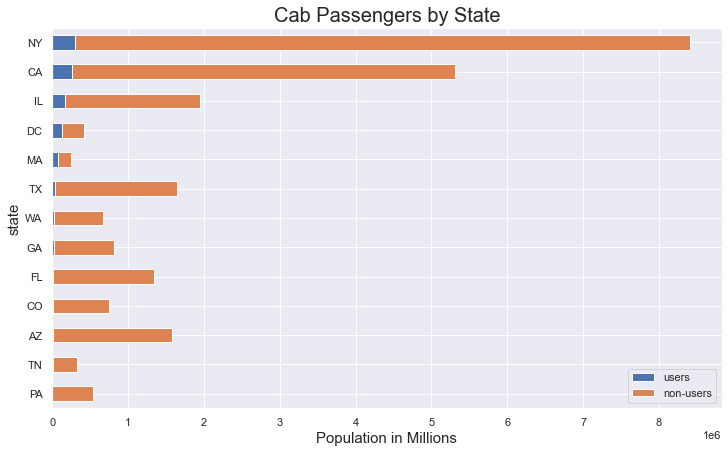

In [47]:
demograph.sort_values(['users', 'population'])[['users', 'non-users']].plot(kind = 'barh', 
                                                                 stacked = True, 
                                                                 figsize = (12, 7), 
                                                                 title = "Cab Passengers by State");

plt.xlabel("Population in Millions");

The state of New York has the highest population of approximatly 8.5 million followed California (around 5.3 million). Both of these states also have the highest number of users, follwed by Illanois, DC and Massachusetts.  

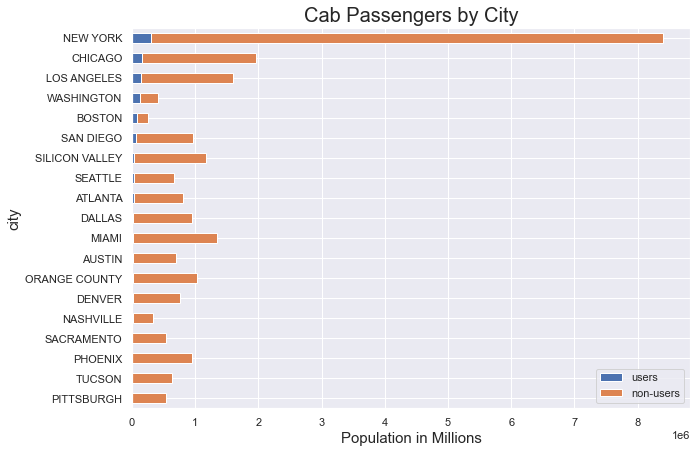

In [48]:
#Visualizing at City level

city_demog = full_df.groupby(['city']).mean()[['population', 'users']].sum(level = 0)

city_demog['non-users'] = city_demog['population'] - city_demog['users']

city_demog.sort_values(['users', 'population'])[['users', 'non-users']].\
                plot(kind = 'barh', stacked = True, figsize = (10, 7), title = "Cab Passengers by City");

plt.xlabel("Population in Millions");

New york city has the highest number of users followed by Chicago, Loas Angeles and Washington.

In [49]:
#Age

full_df.age.describe()

count    359392.000000
mean         35.336705
std          12.594234
min          18.000000
25%          25.000000
50%          33.000000
75%          42.000000
max          65.000000
Name: age, dtype: float64

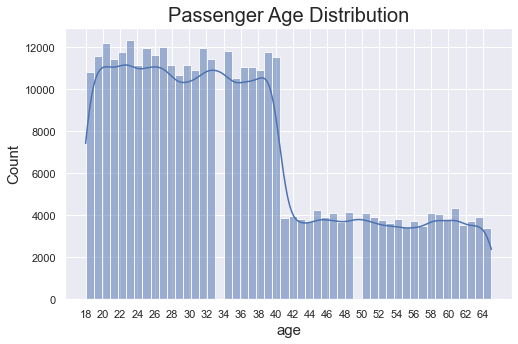

In [50]:
plt.figure(figsize = (8,5))
sns.histplot(full_df.age, kde = True, bins = 50).set_title("Passenger Age Distribution");
plt.xticks(np.arange(18,65,2));

The age distribution of the passengers in the dataset follows a two-phase uniform distribution. According to the data, the highest number of passengers are between the age groups of 18 to 40 year olds. Older passengers above 40 years old untill 65 still make up a sizable portion of passengers. 

Proportion of Male Passengers: 57.29 %
Proportion of Female Passengers: 42.71 %


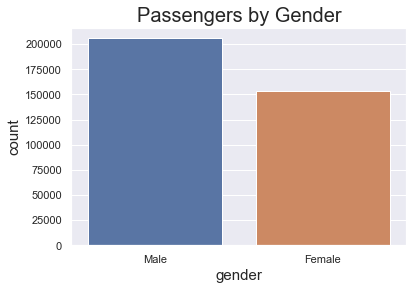

In [51]:
#Gender
print(f'Proportion of Male Passengers: {full_df.gender.value_counts(normalize = True)[0]*100:.2f} %')
print(f'Proportion of Female Passengers: {full_df.gender.value_counts(normalize = True)[1]*100:.2f} %')
sns.countplot(full_df.gender).set_title("Passengers by Gender");

Proportion of Male passengers are higher than female passengers.

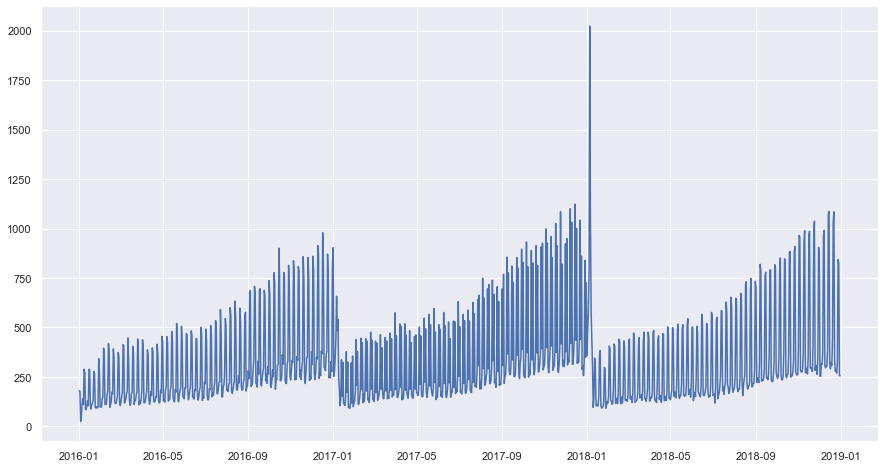

In [52]:
full_df.travel_date.value_counts().plot(figsize = (15,8));

In [53]:
# sns.lineplot(x = 'travel_date')